## This notebook investigates the timing of jerks globally

In [1]:
import sys
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
sys.path.append( os.path.abspath('..') ) #This line needs to point to where-ever the jerks module has been compiled.
from jerks import jerks

In [2]:
# Download the spherical harmonic time-series output from the path model
import os.path
if not os.path.exists('Gauss_Bsurf.mat'): 
    !wget http://morpho.ipgp.fr/4DEarth/Gauss_Bsurf.mat

In [3]:
# import the (Matlab formatted) dataset
import h5py
filepath = 'Gauss_Bsurf.mat'
arrays = {}
f = h5py.File(filepath,'r')
for k, v in f.items():
    arrays[k] = np.array(v)

In [4]:
coeffs = arrays['gnm'][:,:].T
time = arrays['timers'].flatten()
print( 'Shape of gmn array: ', arrays['gnm'].shape )
print ('Times (in years) of output', time )

Shape of gmn array:  (960, 50001)
Times (in years) of output [ 4200.   4200.2  4200.4 ... 14199.6 14199.8 14200. ]


In [5]:
# jerk times as defined in catalogue
jerk_times = [4600,5750,2920, 1915, 6490,7300,7620,7840,8880,9673,10590,12620,13411,13546]

#### Load the ensembles from HPC run created by Python script

In [51]:
import pickle

Nsample = 0  #1M samples
SV_error = 10
filename = "Jerks_5x5_{0:1d}M.results".format(Nsample)

with open(filename, "rb") as fp:   # Unpickling
# get metadata first
    [SV_error, K_MIN, K_MAX, THIN, burn_in, NSAMPLE, \
    relative_sigmas, window_start, window_end, window_length, \
    overlap, thetas, phis] = pickle.load(fp)
# get results
    results = pickle.load(fp)

# The entries have the format:
# [theta,phi,0,jerks_info
# theta, phi,1,jerks_info
# theta, phi,2,jerks_info

# where (theta,phi) is the position
# i is the component (0=x, 1=y, 2=z)
# jerks_info is the list of jerk information

print( [SV_error, K_MIN, K_MAX, THIN, burn_in, NSAMPLE, \
    relative_sigmas, window_start, window_end, window_length, \
    overlap, thetas, phis] )


[10, 0, 100, 100, 100, 1100, array([0.08, 0.02, 0.08]), array([4200, 4600, 5000, 5400, 5800]), array([4600, 5000, 5400, 5800, 6200]), 400, 50, array([ 10.,  60., 110., 160.]), array([-180., -130.,  -80.,  -30.,   20.,   70.,  120.,  170.])]


In [ ]:
time_yearly = np.arange(8880-200,8880+200+1)
ntheta = 33
nphi = 72
Bx_dot_saved = np.zeros((ntheta,nphi,time_yearly.shape[0]))
By_dot_saved = np.zeros((ntheta,nphi,time_yearly.shape[0]))
Bz_dot_saved = np.zeros((ntheta,nphi,time_yearly.shape[0]))
radius = 6371.
phis = np.linspace(-180, 180 , nphi, endpoint=False, dtype=float)
thetas = np.linspace(-80,80, ntheta, endpoint=True, dtype=float) + 90.
for i in range(ntheta):
    for j in range(nphi): 
        theta = thetas[i]
        phi =   phis[j]
        Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
        Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
        Bx_dot_saved[i,j,:], By_dot_saved[i,j,:], Bz_dot_saved[i,j,:] = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)


In [130]:
def plot_map(times = [0,1,2], time_index = 40, component = 4, type='grad_mean',normalise='mean', save = False, max_scale=6):
    ''' Plot a map of the change in slope
    
    Inputs:
    times:  the times at which the model is sampled (array)
    time_index: the time index at which a lot is required (integer). If negative, then sum over time.
    component: 1,2,3 (for Bx, By, Bz) respectively, or 4 for a stacked composite plot
    type: 'grad_mean', 'mean_grad' or 'median_grad'
    normalise: 'mean', 'median' or other. Normalise the gradient by the mean or median over the time period; if other, then don't normalise.
    max_scale: the maximum scale
    
    Outputs:
    Creates a plot
    '''
    
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    (phi_grid,theta_grid), slopes= find_slope_change(results, component = component, type =type, times=times, normalise = normalise)

    if time_index < 0:
        data = slopes.max(axis=2)
    else:
        data = slopes[:,:,time_index]
        
    f, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,12), subplot_kw={'projection': ccrs.Mollweide() }) 

    marker_size = 11. 

    #cax = axes.scatter(phi_grid,90.-theta_grid, s = marker_size, c=slopes[:,:,time_index],cmap=cmap, vmin=0, vmax=10)
    #axes.pcolormesh(slopes[:,:,time_index],origin='upper',extent=(-180,180,90,0) )
    pc = axes.pcolormesh(phi_grid, 90. - theta_grid, data, cmap='viridis_r',vmin=0, vmax=max_scale, transform=ccrs.PlateCarree())
    #gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
    #              linewidth=2, color='gray', alpha=0.5, linestyle='--')

    axes.coastlines()
    if time_index > 0:
        axes.set_title('Change in slope at time {0:4.1f}'.format(times[time_index]) )
    else:
        axes.set_title('Max change in slope over all times')
    axes.top_labels = False
    axes.right_labels = False
    axes.xlines = False
    axes.xlocator = mticker.FixedLocator([-180, -135., -90, -45., 0, 45., 90, 135., 180])
    axes.xformatter = LONGITUDE_FORMATTER
    axes.yformatter = LATITUDE_FORMATTER

    clb = plt.colorbar(pc, ax=axes, shrink=0.30)
    clb.set_label(r'$\Delta$ slope', fontsize=16)

    if save:
        f.savefig('Slope_component'+str(component)+'_type_'+type+'_timeindex'+str(time_index)+'normalise_'+normalise+'.pdf', bbox_inches='tight')


### Map for gradient of the mean

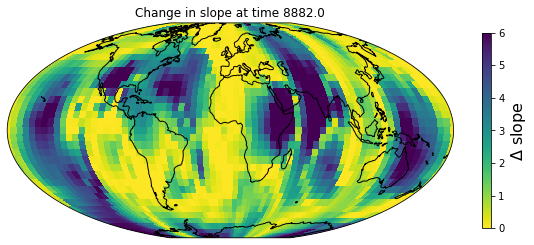

In [66]:
times_for_model = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
plot_map(times_for_model,time_index=50, type='grad_mean',component=1)

In [67]:
### Map for mean of the gradient

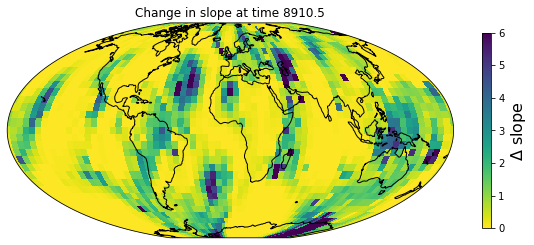

In [68]:
times_for_model = 0.5*( time_intervals_edges[:-1] + time_intervals_edges[1:])
plot_map(times_for_model,time_index=48, type='mean_grad',component=1)

In [69]:
### Map for median of the gradient

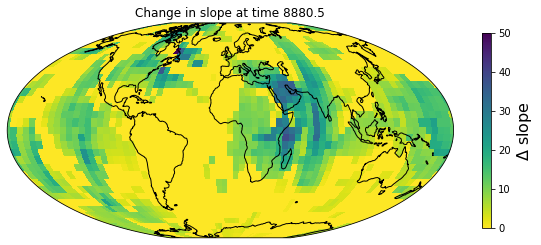

In [70]:
times_for_model = 0.5*( time_intervals_edges[:-1] + time_intervals_edges[1:])
plot_map(times_for_model,time_index=42, type='median_grad',component=0,normalise='mean', save=False, max_scale=50)

In [69]:
### Map for median of the gradient, normalised by mean SV

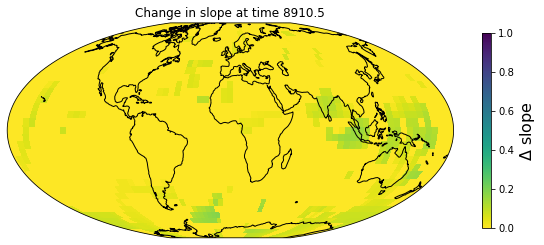

In [138]:
times_for_model = 0.5*( time_intervals_edges[:-1] + time_intervals_edges[1:])
plot_map(times_for_model,time_index=48, type='median_grad',component=4,normalise='meanSV', save=True, max_scale=1)

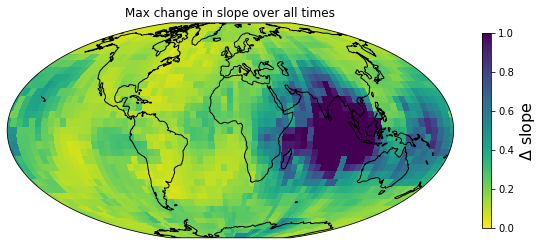

In [145]:
times_for_model = 0.5*( time_intervals_edges[:-1] + time_intervals_edges[1:])
plot_map(times_for_model,time_index=-1, type='median_grad',component=4,normalise='meanSV', save=True, max_scale=1)


In [ ]:
#### Specific locations

45.0 75.0 8870.5


Text(0.5, 1.0, 'Theta=75, phi=45')

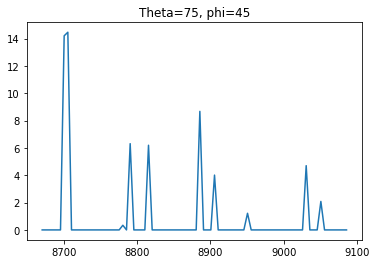

In [228]:
times_for_model = 0.5*( time_intervals_edges[:-1] + time_intervals_edges[1:])

(phi_grid,theta_grid), slopes = find_slope_change(results, component = 0, 
                            type ='median_grad', times=times_for_model , normalise = False)

print(phis[45], thetas[13], times_for_model[40])
# Plot curve for theta = 75, phi = 45. This agrees with workbook 1.

plt.plot(times_for_model, slopes[13,45,:])
plt.title('Theta=75, phi=45')

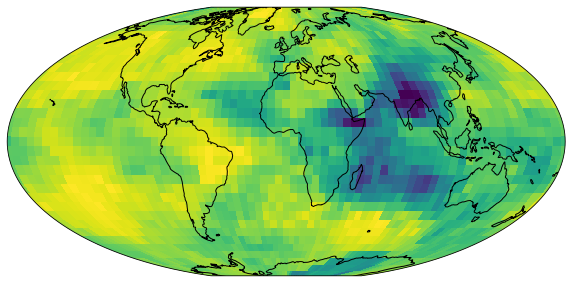

In [235]:
slopes.sum(axis=2)
f, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,12), subplot_kw={'projection': ccrs.Mollweide() }) 

marker_size = 11. 
pc = axes.pcolormesh(phi_grid, 90. - theta_grid, slopes.sum(axis=2), cmap='viridis_r',vmin=0, vmax=100, transform=ccrs.PlateCarree())
    
axes.coastlines()
    

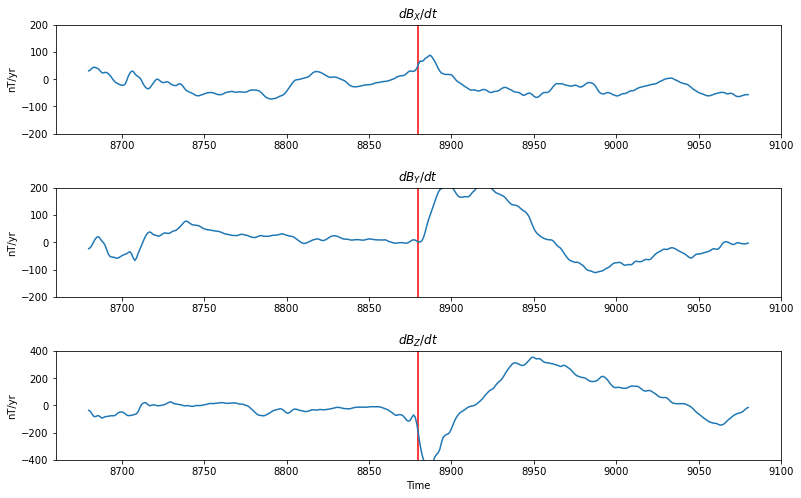

In [161]:
# plot SV series at theta = 90, phi = 45 which is close to the centre point of the jerk event in the SA.
import chaosmagpy as cp

radius = 6371.
theta = 75
phi = 45
jerk_number = 8 # in Python indexing (i.e. event 9)

# sample every year
time_yearly = np.arange(8880-200,8880+200+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)


a = 200
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(13,8) )
ax1.vlines(8880,-a,a,'r')
ax1.plot( time_yearly,Bx_dot )
ax1.set_ylim(-a,a)
ax1.set_ylabel('nT/yr')
ax1.set_title(r'$d{B_X}/dt$')
a=200
ax2.vlines(8880,-a,a,'r')
ax2.plot( time_yearly,By_dot )
#ax2.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
ax2.set_ylim(-200,200)
ax2.set_ylabel('nT/yr')
ax2.set_title(r'$d{B_Y}/dt$')
a=400
ax3.vlines(8880,-a,a,'r')
ax3.plot( time_yearly,Bz_dot )
#ax3.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
ax3.set_ylim(-400,400)
ax3.set_xlabel('Time')
ax3.set_ylabel('nT/yr')
ax3.set_title(r'$d{B_Z}/dt$')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

In [49]:
def plot_interactive( t ):
    plot_map(times_for_model, t)

%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

interactive_plot = interactive(plot_interactive, t=(0,100) )
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot


ModuleNotFoundError: No module named 'ipywidgets'

### Find jerk times (the single highest slope in the given timeseries)

(array([ 37.,   0.,  10.,   4.,  60., 445.,  85.,  24., 102.,   8.]),
 array([8685.5, 8723.5, 8761.5, 8799.5, 8837.5, 8875.5, 8913.5, 8951.5,
        8989.5, 9027.5, 9065.5]),
 <BarContainer object of 10 artists>)

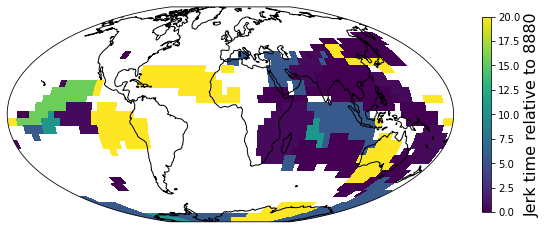

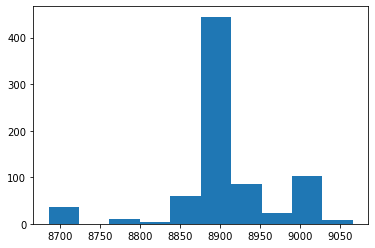

In [148]:
#times_for_model = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
times_for_model = 0.5*( time_intervals_edges[:-1] + time_intervals_edges[1:])

(phi_grid,theta_grid), slopes = find_slope_change(results, component = 0, 
                            type ='median_grad', times=times_for_model , normalise = 'meanSV')
jerk_times = np.zeros( (slopes.shape[0], slopes.shape[1]), dtype=float)
threshold = 0.3
for i in range(slopes.shape[0]):
    for j in range(slopes.shape[1]):
        jerk_times[i,j] = times_for_model[slopes[i,j,:].argmax() ]
        if slopes[i,j,:].max() < threshold:
            jerk_times[i,j] = np.nan
            
jerk_min_time =  8880

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

f, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,12), subplot_kw={'projection': ccrs.Mollweide() }) 
marker_size = 11. 

#cax = axes.scatter(phi_grid,90.-theta_grid, s = marker_size, c=slopes[:,:,time_index],cmap=cmap, vmin=0, vmax=10)
#axes.pcolormesh(slopes[:,:,time_index],origin='upper',extent=(-180,180,90,0) )
pc = axes.pcolormesh(phi_grid, 90. - theta_grid, jerk_times[:,:]-jerk_min_time, cmap='viridis',vmin = 0, vmax=20, transform=ccrs.PlateCarree())
#gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
#              linewidth=2, color='gray', alpha=0.5, linestyle='--')

axes.coastlines()
#axes.set_title('Delta at time {0:f}'.format(times[time_index]) )
axes.top_labels = False
axes.right_labels = False
axes.xlines = False
axes.xlocator = mticker.FixedLocator([-180, -135., -90, -45., 0, 45., 90, 135., 180])
axes.xformatter = LONGITUDE_FORMATTER
axes.yformatter = LATITUDE_FORMATTER

clb = plt.colorbar(pc, ax=axes, shrink=0.30)
clb.set_label('Jerk time relative to {0:d}'.format(jerk_min_time), fontsize=16)

plt.figure()
plt.hist(jerk_times[~np.isnan(jerk_times)])

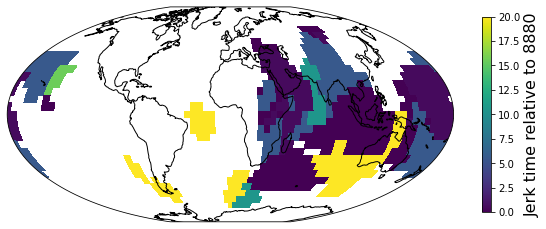

In [152]:
times_for_model = 0.5*( time_intervals_edges[:-1] + time_intervals_edges[1:])
component = 2
type = 'median_grad'
(phi_grid,theta_grid), slopes = find_slope_change(results, component = component, 
                            type = type, times=times_for_model , normalise = 'meanSV')
jerk_times = np.zeros( (slopes.shape[0], slopes.shape[1]), dtype=float)
threshold = 0.3
for i in range(slopes.shape[0]):
    for j in range(slopes.shape[1]):
        jerk_times[i,j] = times_for_model[slopes[i,j,:].argmax() ]
        if slopes[i,j,:].max() < threshold:
            jerk_times[i,j] = 'NaN'
            
jerk_min_time =  8880

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

f, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,12), subplot_kw={'projection': ccrs.Mollweide() }) 
marker_size = 11. 

#cax = axes.scatter(phi_grid,90.-theta_grid, s = marker_size, c=slopes[:,:,time_index],cmap=cmap, vmin=0, vmax=10)
#axes.pcolormesh(slopes[:,:,time_index],origin='upper',extent=(-180,180,90,0) )
pc = axes.pcolormesh(phi_grid, 90. - theta_grid, jerk_times[:,:]-jerk_min_time, cmap='viridis',vmin = 0, vmax=20, transform=ccrs.PlateCarree())
#gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
#              linewidth=2, color='gray', alpha=0.5, linestyle='--')

axes.coastlines()
#axes.set_title('Delta at time {0:f}'.format(times[time_index]) )
axes.top_labels = False
axes.right_labels = False
axes.xlines = False
axes.xlocator = mticker.FixedLocator([-180, -135., -90, -45., 0, 45., 90, 135., 180])
axes.xformatter = LONGITUDE_FORMATTER
axes.yformatter = LATITUDE_FORMATTER

clb = plt.colorbar(pc, ax=axes, shrink=0.30)
clb.set_label('Jerk time relative to {0:d}'.format(jerk_min_time), fontsize=16)

f.savefig('Jerk_timing_component'+str(component)+'_type_'+type+'threshold'+str(threshold)+'.pdf', bbox_inches='tight')

In [ ]:
# Make plot of which component jerks first

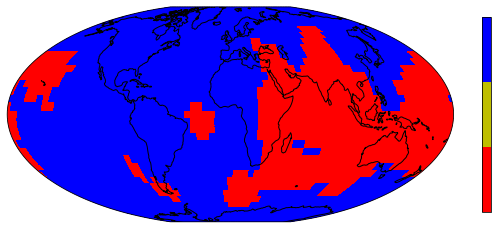

In [172]:
from matplotlib.pyplot import *

times_for_model = 0.5*( time_intervals_edges[:-1] + time_intervals_edges[1:])
jerk_times = np.zeros( (slopes.shape[0], slopes.shape[1],3), dtype=float)

for component in range(3):

    (phi_grid,theta_grid), slopes = find_slope_change(results, component = component, 
                                type = 'median_grad', times=times_for_model , normalise = 'meanSV')
    threshold = 0.3
    for i in range(slopes.shape[0]):
        for j in range(slopes.shape[1]):
            jerk_times[i,j] = times_for_model[slopes[i,j,:].argmax() ]
            if slopes[i,j,:].max() < threshold:
                jerk_times[i,j,component] = 'NaN'
    jerk_min_time =  8880

jerk_colour = np.zeros( (slopes.shape[0], slopes.shape[1],3), dtype=int)
jerk_colour = np.argmin(jerk_times,axis=2)
            
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

f, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,12), subplot_kw={'projection': ccrs.Mollweide() }) 
marker_size = 11. 

#cax = axes.scatter(phi_grid,90.-theta_grid, s = marker_size, c=slopes[:,:,time_index],cmap=cmap, vmin=0, vmax=10)
#axes.pcolormesh(slopes[:,:,time_index],origin='upper',extent=(-180,180,90,0) )
discrete   = matplotlib.colors.ListedColormap( [ 'r', 'y', 'b' ] )
pc = axes.pcolormesh(phi_grid, 90. - theta_grid, jerk_colour[:,:], cmap=discrete,vmin = 0, vmax=2, transform=ccrs.PlateCarree())
#gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
#              linewidth=2, color='gray', alpha=0.5, linestyle='--')

axes.coastlines()
#axes.set_title('Delta at time {0:f}'.format(times[time_index]) )
axes.top_labels = False
axes.right_labels = False
axes.xlines = False
axes.xlocator = mticker.FixedLocator([-180, -135., -90, -45., 0, 45., 90, 135., 180])
axes.xformatter = LONGITUDE_FORMATTER
axes.yformatter = LATITUDE_FORMATTER

clb = plt.colorbar(pc, ax=axes, shrink=0.30, boundaries = [0,1,2],ticks=[] )


In [160]:
np.where(jerk_colour == 1)

(array([], dtype=int64), array([], dtype=int64))

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

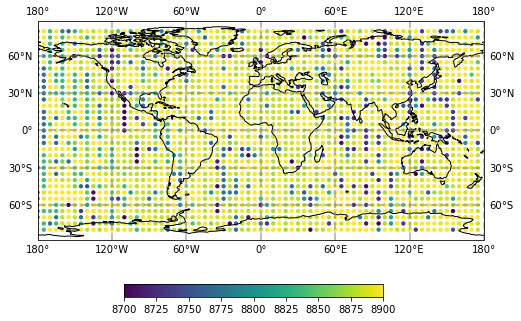

In [38]:
def find_jerk_time():
    ntheta = 33
    nphi = 72
    phis = np.linspace(-180, 180 , nphi, endpoint=False, dtype=float)
    thetas = np.linspace(-80,80, ntheta, endpoint=True, dtype=float) + 90.
# create an array in which to stack the components and find the max time.
    delta_array = np.zeros((thetas.shape[0], phis.shape[0], time_intervals_edges.shape[0]-1),dtype=float)
    jerk_time = np.zeros((thetas.shape[0], phis.shape[0]),dtype=float)
# cycle through results 
    for j in range(len(results)):
        theta_index = np.where(thetas==results[j][0])[0][0]
        phi_index = np.where(phis == results[j][1] )[0][0]
# add all components
        delta_array[theta_index,phi_index,:] += results[j][4][:] + results[j][9][:] + results[j][14][:]
        #if( (theta_index == 13) and (phi_index == 45)):
        #    print( results[j][4][:] ) 
        #    print('')
        #print( theta_index, phi_index)
    for i in range(len(thetas)):
        for j in range(len(phis)):
            time_index = delta_array[i,j,:].argmax()
            jerk_time[i,j] = 0.5*(time_intervals_edges[time_index] + time_intervals_edges[time_index+1])
            if( (abs(thetas[i]-80.) < 1.0e-4) and (abs(phis[j]-65.) < 1e-4)):
                temp = (delta_array[i,j])
    
    return thetas, phis, jerk_time, temp   
    

    
thetas, phis , jerk_times, temp = find_jerk_time()
plt.figure()
a,b = np.meshgrid(thetas, phis)

plt.figure()
f, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,12),subplot_kw={'projection': ccrs.PlateCarree() }) 
marker_size = 11. 

cax = axes.scatter(b,90.-a, s = 11, c=jerk_times,cmap='viridis',vmin = 8700, vmax = 8900)
gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

axes.coastlines()
cb_ax = f.add_axes([0.20, 0.31, 0.6, 0.1])
    #cb_ax.scatter([0,1,2,3],[0,1,2,3],[0,1,2,4])
cbar = f.colorbar(cax, ax=cb_ax, orientation = 'horizontal')
cb_ax.set_axis_off()


80.0 65.0
8880.5


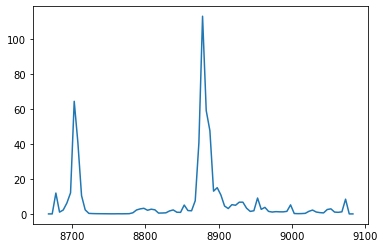

In [39]:
thetas, phis , jerk_times, temp = find_jerk_time()
plt.figure()
plt.plot( time_intervals_edges[:-1], temp)
print(thetas[14] ,phis[49])
print(jerk_times[14,49])


In [20]:
print( jerk_times.max() )

9075.5


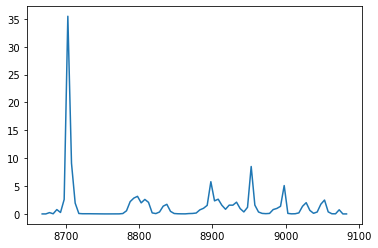

In [40]:
for j in range(len(results)):
    if( results[j][0] == 80. and results[j][1] == 65.) :
        a = results[j][4] 
plt.figure()
plt.plot(time_intervals_edges[:-1],a)

In [108]:
jerk_number = 8 # in Python indexing (i.e. event 9)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)



run_components=[0,1,2] #compute for X,Y,Z components of SV

SV_errors = np.array([5,10,15,20])
num_SV_errors = SV_errors.shape[0]

discretise_size = 100
time_yearly = np.arange(jerk_times[jerk_number]-200,jerk_times[jerk_number]+200+1)

TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()
    
# ****************************************
# Define diagnostic time bins here
# ****************************************
time_intervals_edges = np.arange(TIMES_MIN,TIMES_MAX+1,3) #return bin spacing of 3 years, up to and including the end point if appropriate.
time_intervals_nbins = time_intervals_edges.shape[0]-1
delta_hist_save = np.zeros( (num_SV_errors,len(run_components),time_intervals_nbins), dtype=float )
CP_hist_save = np.zeros( (num_SV_errors,len(run_components),time_intervals_nbins), dtype=int )
Acceptance_rates_save = np.zeros( (num_SV_errors,len(run_components),4),dtype=float)

for error_j_index, error_j in enumerate(SV_errors):
    
    for run_component_index,i in enumerate(run_components):
        if i == 0:
            SV = Bx_dot
        elif i == 1:
            SV = By_dot
        else:
            SV = Bz_dot

        delta_SV = error_j * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
        SV_MIN = -400
        SV_MAX = 400

        K_MIN = 0
        K_MAX = 100
        sigmas = np.array([20,10,20],dtype = float)
        TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
        # sigma_change_value = sigmas(1)
        # sigma_move = sigmas(2)
        # sigma_birth = sigmas(3)

        THIN = 100
        NBINS = 100
        credible = 0.0
        RUNNING_MODE = 1
        burn_in = 10000
        NSAMPLE = 2000000+burn_in
        Acceptance_rates=np.zeros(4)
        AV = np.zeros(discretise_size,dtype=float)
        SUP = np.zeros(discretise_size,dtype=float)
        INF = np.zeros(discretise_size,dtype=float)
        MEDIAN = np.zeros(discretise_size,dtype=float)
        MODE = np.zeros(discretise_size,dtype=float)
        MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
        N_CP_hist = np.zeros( K_MAX, dtype=int)
        delta_slope = np.zeros( time_intervals_nbins,dtype=float )
        CP = np.zeros( time_intervals_nbins, dtype=int )

        (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP, delta_slope, MARGINAL_DENSITY, N_CP_hist) = jerks.rjmcmc(
         sigmas=sigmas, burn_in=burn_in, 
         nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
         y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
         k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
         thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)

        CP_hist_save[error_j_index,run_component_index,:] = CP[:]
        delta_hist_save[error_j_index,run_component_index,:] = delta_slope[:]
        Acceptance_rates_save[error_j_index,run_component_index,:] = Acceptance_rates[:]
    

In [109]:
# Acceptance rates for SV errors, averaged over the vector components.

# The sigma parameters seem to generate acceptable acceptance ratios.
print(np.sum(Acceptance_rates_save[:,:,:]/Acceptance_rates_save.shape[1],axis=1))


[[28.27283287 16.45110003  3.93178105  3.94220352]
 [42.02626673 28.04337056  5.85369444  5.86995681]
 [49.56986872 34.85435677  6.93889523  6.95797205]
 [54.32329941 40.43412145  7.59780264  7.61879953]]


1

#### Stacked data:

<Figure size 432x288 with 0 Axes>

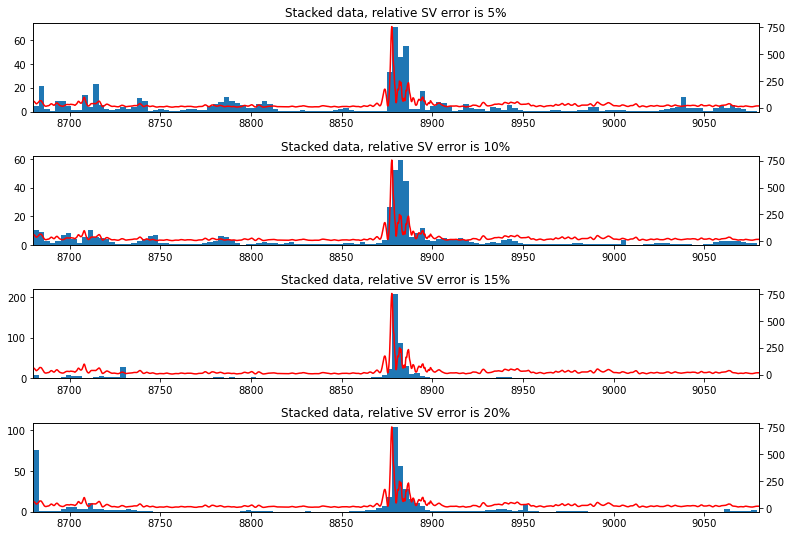

In [110]:
plt.figure()

f, ax = plt.subplots(delta_hist_save.shape[0], 1, figsize=(13,9) )
left_edges = time_intervals_edges[:-1]
time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
fac = (NSAMPLE-burn_in)/THIN

for i in range(ax.shape[0]):
    ax[i].set_title(r'Stacked data, relative SV error is {0:d}%'.format(SV_errors[i]))
    ax[i].bar(left_edges, np.sum(delta_hist_save[i,:,:],axis=0), align='edge', width = 1*(left_edges[1] - left_edges[0]))
    axb = ax[i].twinx()
    axb.plot(time_EJ, EJ,'r' )
    ax[i].set_xlim(time_yearly.min(), time_yearly.max() )

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)




<Figure size 432x288 with 0 Axes>

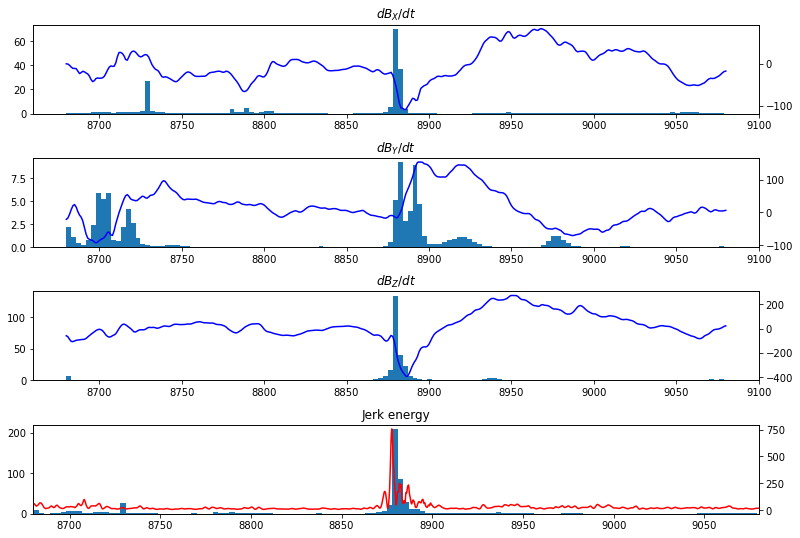

In [114]:
plt.figure()
f, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(13,9) )
left_edges = time_intervals_edges[:-1]
fac = (NSAMPLE-burn_in)/THIN
error_index = 2  #15% error
ax1.bar(left_edges, delta_hist_save[error_index,0,:], align='edge', width = 1*(left_edges[1] - left_edges[0]))
ax2.bar(left_edges, delta_hist_save[error_index,1,:], align='edge', width = 1*(left_edges[1] - left_edges[0]))
ax3.bar(left_edges, delta_hist_save[error_index,2,:], align='edge', width = 1*(left_edges[1] - left_edges[0]))

ax1b = ax1.twinx()
ax1b.plot(TIMES,Bx_dot,'b')
ax2b = ax2.twinx()
ax2b.plot(TIMES,By_dot,'b')
ax3b = ax3.twinx()
ax3b.plot(TIMES,Bz_dot,'b')

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax4b = ax4.twinx()
ax4.bar(left_edges, delta_hist_save[error_index,:,:].sum(axis=0), align='edge', width = 1*(left_edges[1] - left_edges[0]))
ax4b.plot(time_EJ, EJ,'r' )

ax4.set_xlim(time_yearly.min(), time_yearly.max() )
ax4.set_title('Jerk energy')

ax1.set_title(r'$d{B_X}/dt$')
ax2.set_title(r'$d{B_Y}/dt$')
ax3.set_title(r'$d{B_Z}/dt$')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
#plt.savefig('Jerk9_xyz_like_'+str(SV_error)+'.pdf')


#### Jerk time from delta slope or change point probability:

In [121]:
time_index_delta = np.argmax(np.sum(delta_hist_save[2,:,:],axis=0))
print('Jerk time from delta slope is {0:f}'.
      format( (time_intervals_edges[time_index_delta] + time_intervals_edges[time_index_delta+1])/2.0))


Jerk time from delta slope is 8879.500000


In [ ]:
# Animate time window for jerk 9
plt.close('all')
import numpy as np
import pickle
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

jerk_number = 8

# jerk times as defined in catalogue
jerk_times = [4605,5750,2920, 1915, 6450,7295,7620,7844,8878,9673,10593,12619,13412,13543]
# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-200,jerk_times[jerk_number]+200+1)
t0 = jerk_times[jerk_number]
f_size = 16  # fontsize for figure

time_intervals_edges = np.arange(-210,211,20) + jerk_times[jerk_number]
Nsample = 100

filename = "../ensemble_diagnostics/Jerk{0:1d}_5x5_{1:d}M_20yr.results".format(jerk_number+1,Nsample)

with open(filename, "rb") as fp:   # Unpickling
     results = pickle.load(fp)

for l in range(0,21):
    
    y_theta, y_phi, y_delta = [],[],[]

    for j in range(len(results)):
        theta = results[j][0]
        phi = results[j][1]
        component = 1
        delta = results[j][9][l]  # this is the element that spans the event


        y_theta.append(theta)
        y_phi.append(phi)
    # normalise by average value at location:
        y_delta.append ( delta /np.mean(results[j][9] ))

    cmap = plt.get_cmap('viridis')
    plt.figure()

    f, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,12),subplot_kw={'projection': ccrs.PlateCarree() }) 
    #y_delta = np.array(y_delta)
    marker_size = 11. 

    axes.set_title('Time bin ' + str(time_intervals_edges[l]) + '-' + str(time_intervals_edges[l+1]))
    cax = axes.scatter(y_phi,90.-np.array(y_theta), s = marker_size, c=y_delta,cmap=cmap, vmin=0, vmax=10)
    gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    axes.coastlines()

    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.xlocator = mticker.FixedLocator([-180, -135., -90, -45., 0, 45., 90, 135., 180])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    cb_ax = f.add_axes([0.20, 0.31, 0.6, 0.1])
    #cb_ax.scatter([0,1,2,3],[0,1,2,3],[0,1,2,4])
    cbar = f.colorbar(cax, ax=cb_ax, orientation = 'horizontal')
    cb_ax.set_axis_off()


    outfname = 'Jerk_delta_map_{0:d}_5x5_{1:d}M_timeindex{2:02d}'.format(jerk_number+1, Nsample, l)
    f.savefig(outfname + '.png',bbox_inches = 'tight',dpi=400)
    plt.close()

In [118]:
for i in range(100):
    Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)

In [120]:
?cp.model_utils.synth_values

Signature:
cp.model_utils.synth_values(
    coeffs,
    radius,
    theta,
    phi,
    *,
    nmax=None,
    nmin=None,
    mmax=None,
    source=None,
    grid=None,
)
Docstring:
Computes radial, colatitude and azimuthal field components from the
magnetic potential field in terms of spherical harmonic coefficients.

Parameters
----------

coeffs : ndarray, shape (..., M)
    Coefficients of the spherical harmonic expansion. The last dimension is
    equal to the number of coefficients.
radius : float or ndarray, shape (...)
    Array containing the radius in kilometers.
theta : float or ndarray, shape (...)
    Array containing the colatitude in degrees
    :math:`[0^\circ,180^\circ]`.
phi : float or ndarray, shape (...)
    Array containing the longitude in degrees.
nmax : int, positive, optional
    Maximum degree up to which expansion is to be used (default is given by
    the last dimension of ``coeffs``, that is, ``M = nmax(nmax+2)``). This
    value can also be smaller if only 